In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.layers import *
import tensorflow.keras.backend as K
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sbn
import os
from functools import cmp_to_key
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from deepctr.inputs import SparseFeat, DenseFeat, VarLenSparseFeat, get_feature_names
from deepctr.models import DeepFM
import pickle
from tensorflow.keras import layers
import time
from tensorflow import feature_column
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import sys
%matplotlib inline

In [3]:
print(tf.version.VERSION)
print('{}.{}'.format(sys.version_info.major,sys.version_info.minor))

2.1.0
3.6


In [4]:
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [5]:
tf.keras.backend.clear_session()

In [6]:
def load_dict_from_file(file, type='default', skiprow = 0):
    data = list()
    size = 0
    with open(file, encoding='utf-8') as f:
        for line in f:
            size += 1
            try:
                if size <= skiprow:
                    continue
                line = line.replace('"', '').strip()
                if len(line) <= 0:
                    continue
                if type == 'interet':
                    parts = line.split(",")
                    name = parts[0]
                    size = int(parts[1])
                    if size > 10 and len(name) > 0:
                        data.append(name)
                elif type == 'loc':
                    parts = line.split(",")
                    province = parts[0]
                    city = parts[1]
                    area = parts[2]
                    data.append(province)
                    data.append(province + "_" + city)
                    data.append(province + "_" + city + "_" + area)
                elif type == 'publisher':
                    parts = line.split(",")
                    name = parts[0]
                    size = int(parts[1])
                    if size > 10:
                        data.append(name)
                else:
                    data.append(line)
            except:
                print(line)
    return data

def load_dict(dir, type='default', skiprow = 0):
    data = list()
    size = 0
    files = os.listdir(dir)
    for file in files:
        if not file.endswith(".csv"):
            continue
        data+=load_dict_from_file(dir + "/" + file, type, skiprow)
    return list(set(data))

def save_pickle_data(file, data):
    f = open(file, 'wb')
    pickle.dump(data, f)
    f.close()


def load_pickle_data(file):
    try:
        f1 = open(file, 'rb')
        return pickle.load(f1)
    except:
        pass
    return None

lbe_file = 'lbe.pickle'
data_map_file = 'data_map.pickle'

its = load_dict('/home/recsys/dataset/dict/interets', 'interet')
locs = load_dict('/home/recsys/dataset/dict/loc', 'loc')
publishers = load_dict('/home/recsys/dataset/dict/publisher', 'publisher', 1)
cates = load_dict_from_file('/home/recsys/dataset/dict/cate.csv', 'cate', 1)
channels = load_dict_from_file('/home/recsys/dataset/dict/channel.csv', 'channel', 1)
publishers.append('other')
channels.append('')

u_levels = [str(i) for i in range(0, 10)]
media_levels = [str(i) for i in range(0, 10)]
rschannles = [str(i) for i in range(1, 33)]
vocabs = dict()
vocabs['u_level'] = u_levels
vocabs['t_channel'] = channels
vocabs['cp_l1_category'] = cates
vocabs['cp_publisher'] = publishers
vocabs['cp_media_level'] = media_levels
vocabs['rschannles'] = rschannles

def load_dataset(dir_paths):
    files = []
    for dir_path in dir_paths:
        files += os.listdir(dir_path)
        print(dir_path)
    dataset = tf.data.TFRecordDataset(filenames = [dir_path + '/' + file for file in files], num_parallel_reads= tf.data.experimental.AUTOTUNE )
    return dataset

def list_sort_files(dir):
    def compare(x, y):
        stat_x = int(x.replace('-', ''))
        stat_y = int(y.replace('-', ''))
        if stat_x < stat_y:
            return -1
        elif stat_x > stat_y:
            return 1
        else:
            return 0
    items = os.listdir(dir)
    items.sort(key = cmp_to_key(compare))
    return items

dir = '/home/recsys/dataset/train_v2'
files = list_sort_files('/home/recsys/dataset/train_v2')

Sky game
中国新闻网,绥芬河政府网站,1
Ansun Biopharma, Inc.,1


In [7]:
train_files = [dir + "/" + file + "/train" for file in files[:15]] + [dir + "/" + file + "/test" for file in files[:15]]
test_files = [dir + "/" + file + "/train" for file in files[16:17]] + [dir + "/" + file + "/test" for file in files[16:17]]

print("load train dataset")
train = load_dataset(train_files)
print("load test dataset")
test = load_dataset(test_files)

# for raw_record in train.take(1):
#     example = tf.train.Example()
#     example.ParseFromString(raw_record.numpy())
#     print(type(example))

# 用于创建一个特征列
# 并转换一批次数据的一个实用程序方法
def demo(feature_column):
    feature_layer = layers.DenseFeatures(feature_column)
    return feature_layer(example_batch).numpy()

load train dataset
/home/recsys/dataset/train_v2/2020-05-20-00/train
/home/recsys/dataset/train_v2/2020-05-20-01/train
/home/recsys/dataset/train_v2/2020-05-20-02/train
/home/recsys/dataset/train_v2/2020-05-20-03/train
/home/recsys/dataset/train_v2/2020-05-20-04/train
/home/recsys/dataset/train_v2/2020-05-20-05/train
/home/recsys/dataset/train_v2/2020-05-20-06/train
/home/recsys/dataset/train_v2/2020-05-20-07/train
/home/recsys/dataset/train_v2/2020-05-20-08/train
/home/recsys/dataset/train_v2/2020-05-20-09/train
/home/recsys/dataset/train_v2/2020-05-20-10/train
/home/recsys/dataset/train_v2/2020-05-20-11/train
/home/recsys/dataset/train_v2/2020-05-20-12/train
/home/recsys/dataset/train_v2/2020-05-20-13/train
/home/recsys/dataset/train_v2/2020-05-20-14/train
/home/recsys/dataset/train_v2/2020-05-20-00/test
/home/recsys/dataset/train_v2/2020-05-20-01/test
/home/recsys/dataset/train_v2/2020-05-20-02/test
/home/recsys/dataset/train_v2/2020-05-20-03/test
/home/recsys/dataset/train_v2/2020-

###### 选择特征列 
uid, u_umi, u_umi_weight, u_uli, u_uli_weight, u_usi, u_usi_weight, u_level

t_channel, t_location

item_id, cp_l1_category, cp_interests, cp_location, cp_publisher, cp_media_level, cp_life_hour

rs_channel, rs_gactr, rs_taginfo, rs_taginfo_weight, rs_dactr

In [8]:
import os
import time
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence

class NumpyFunctionHelper:
    def __init__(self, maxlen=None, dtype='int32', padding='post', truncating='post', value=0.0):
        self.maxlen = maxlen
        self.dtype = dtype
        self.padding = padding
        self.truncating = truncating
        self.value = value
        self.out_dtype = tf.int32
        if self.dtype == 'int64':
            self.out_dtype = tf.int64
        elif self.dtype == 'float32':
            self.out_dtype = tf.float32
        elif self.dtype == 'str':
            self.out_dtype = tf.string
        return

    def pad_sequences(self, x):
        # x will be a numpy array with the contents of the input to the
        # tf.function
        # note: x will be processed as a list of sequences
        return sequence.pad_sequences(x,
                                      maxlen = self.maxlen,
                                      dtype = self.dtype,
                                      padding = self.padding,
                                      truncating = self.truncating,
                                      value = self.value)

    # tf.numpy_function用于将一个numpy函数转换为一个tensor的operator，以便嵌入到计算图中处理Tensor
    # 构造一个能支持Tensor的填充截断函数
    # 调用方法NumpyFunctionHelper.tf_pad_sequences(helper, in_tensor)
    @tf.function(experimental_relax_shapes=True)
    def tf_pad_sequences(self, in_tensor):
        y = tf.numpy_function(self.pad_sequences, [in_tensor], self.out_dtype)
        return y

    # 毫秒时间戳转换为local的struct_time
    def timestamp_to_time(self, ts):
        st = time.localtime(ts/1000)
        return tf.constant([st.tm_mon, st.tm_mday, st.tm_hour, st.tm_min, st.tm_wday])

    @tf.function(experimental_relax_shapes=True)
    def tf_timestamp_to_time(self, ts):
        y = tf.py_function(self.timestamp_to_time, ts, self.out_dtype)
        return y
    
    def pad_float_sequences(self, x):
        lst = x.tolist()
        res = []
        if len(x) < self.maxlen:
            for i in range(self.maxlen - len(x)):
                res.append(0.0)

        return np.asarray(lst + res, dtype=np.float32)[:self.maxlen]
    
    @tf.function(experimental_relax_shapes=True)
    def tf_pad_float_sequences(self, in_tensor):
        y = tf.numpy_function(self.pad_float_sequences, [in_tensor], tf.float32)
        return y
    
    def pad_str_sequences(self, x):
        lst = x.tolist()
        res = []
        if len(x) < self.maxlen:
            for i in range(self.maxlen - len(x)):
                res.append(b'<PAD>')

        return np.asarray(lst + res)[:self.maxlen]
    
    @tf.function(experimental_relax_shapes=True)
    def tf_pad_str_sequences(self, in_tensor):
        y = tf.numpy_function(self.pad_str_sequences, [in_tensor], tf.string)
        return y

#### long interest 50 middle interest 20 short interest 15

In [9]:
spc = "t_location:3;u_uli_interest:50;u_uli_interest_weight:50;u_uli_cate:10;u_uli_cate_weight:10;"\
+"u_umi_interest:20;u_umi_interest_weight:20;u_umi_cate:10;u_umi_cate_weight:10;"\
+"u_usi_interest:15;u_usi_interest_weight:15;u_usi_cate:5;u_usi_cate_weight:5;"\
+"cp_category:3;cp_category_weight:3;cp_interests:8;cp_interests_weight:8;cp_location:3;cp_location_weight:3;"\
+"rs_channel:16;"\
+"rs_tag_interest:8;rs_tag_interest_dactr:8;rs_tag_cate:3;rs_tag_cate_dactr:3"
sparse_configs = [{'key':item.split(":")[0], 'max_len':int(item.split(":")[1])} for item in spc.split(";")]

for config in sparse_configs:
    key = config['key']
    max_len = config['max_len']
    dtype=tf.string
    value=b'<PAD>'
    if key.endswith('weight') or key.endswith('dactr'):
        dtype=tf.float32
        value=0.0

In [10]:
def parse_function(example_proto):
    dics = {
            'request_id':tf.io.FixedLenFeature(shape=(),dtype=tf.string, default_value=''),
            'report_time': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            't_language': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            't_country': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            't_pid': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            't_ip': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            't_channel': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            't_scene': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            't_action': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            't_ctype': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            't_location': tf.io.VarLenFeature(dtype=tf.string),
            'uid': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            'u_level': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            'u_uli_interest': tf.io.VarLenFeature(dtype=tf.string),
            'u_uli_interest_weight': tf.io.VarLenFeature(dtype=tf.float32),
            'u_uli_cate': tf.io.VarLenFeature(dtype=tf.string),
            'u_uli_cate_weight': tf.io.VarLenFeature(dtype=tf.float32),
            'u_umi_interest': tf.io.VarLenFeature(dtype=tf.string),
            'u_umi_interest_weight': tf.io.VarLenFeature(dtype=tf.float32),
            'u_umi_cate': tf.io.VarLenFeature(dtype=tf.string),
            'u_umi_cate_weight': tf.io.VarLenFeature(dtype=tf.float32),
            'u_usi_interest': tf.io.VarLenFeature(dtype=tf.string),
            'u_usi_interest_weight': tf.io.VarLenFeature(dtype=tf.float32),
            'u_usi_cate': tf.io.VarLenFeature(dtype=tf.string),
            'u_usi_cate_weight': tf.io.VarLenFeature(dtype=tf.float32),
            'item_id': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            'cp_publisher': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            'cp_media_level': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            'cp_publish_time': tf.io.FixedLenFeature(shape=(), dtype=tf.string, default_value=''),
            'cp_life_hour': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            'cp_newsy_score': tf.io.FixedLenFeature(shape=(), dtype=tf.float32, default_value=0),
            'cp_word_count': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            'cp_category': tf.io.VarLenFeature(dtype=tf.string),
            'cp_category_weight': tf.io.VarLenFeature(dtype=tf.float32),
            'cp_interests': tf.io.VarLenFeature(dtype=tf.string),
            'cp_interests_weight': tf.io.VarLenFeature(dtype=tf.float32),
            'cp_location': tf.io.VarLenFeature(dtype=tf.string),
            'cp_location_weight': tf.io.VarLenFeature(dtype=tf.float32),
            'cp_list_image_count': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            'cp_clickbait_type': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            'cp_vulgar_type': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            'cp_product_type': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            'cp_is_local': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            'cp_is_local_publisher': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
            'rs_channel': tf.io.VarLenFeature(dtype=tf.string),
            'rs_p1_score': tf.io.FixedLenFeature(shape=(), dtype=tf.float32, default_value=0.0),
            'rs_gactr': tf.io.FixedLenFeature(shape=(), dtype=tf.float32, default_value=0.0),
            'rs_tag_interest': tf.io.VarLenFeature(dtype=tf.string),
            'rs_tag_interest_dactr': tf.io.VarLenFeature(dtype=tf.float32),
            'rs_tag_cate': tf.io.VarLenFeature(dtype=tf.string),
            'rs_tag_cate_dactr': tf.io.VarLenFeature(dtype=tf.float32),
            'action': tf.io.FixedLenFeature(shape=(), dtype=tf.int64, default_value=0),
           }
    # parse all features in a single example according to the dics
    parsed_example = tf.io.parse_single_example(example_proto, dics)
    for config in sparse_configs:
        key = config['key']
        print(key)
        dtype='str'
        value=b'<PAD>'
        if key.endswith('weight') or key.endswith('dactr'):
            dtype=tf.float32
            value=0.0
            h = NumpyFunctionHelper(maxlen=config['max_len'], dtype=dtype, value=value)
            parsed_example[key] = NumpyFunctionHelper.tf_pad_float_sequences(h, tf.sparse.to_dense(parsed_example[key]))
            parsed_example[key].set_shape([config['max_len']])
        else:
            h = NumpyFunctionHelper(maxlen=config['max_len'], dtype=dtype, value=value)
            parsed_example[key] = NumpyFunctionHelper.tf_pad_str_sequences(h, tf.sparse.to_dense(parsed_example[key]))
            parsed_example[key].set_shape([config['max_len']])
    
    parsed_example['cp_media_level'] = tf.strings.as_string(parsed_example['cp_media_level'])
    parsed_example['u_level'] = tf.strings.as_string(parsed_example['u_level'])
    target = parsed_example['action']
    del parsed_example['action']
    return parsed_example, target
train_dataset = train.map(parse_function)
test_dataset = test.map(parse_function)

new_dataset = train_dataset
new_dataset = new_dataset.batch(2)
example_batch = next(iter(new_dataset))[0]

# # feature_column.categorical_column_with_vocabulary_list(key='u_level', vocabulary_list=u_levels, num_oov_buckets=1)
for feature_batch, label_batch in new_dataset.take(1):
    print('Every feature:', list(feature_batch.keys()))
#     print('A batch of u_uli:', feature_batch['u_uli'])
    print('A batch of request_id:', feature_batch['request_id'])
#     print('A batch of item_id:', feature_batch['u_uli'])
    print('A batch of cp_clickbait_type:', feature_batch['cp_clickbait_type'])
    print('A batch of targets:', label_batch )


t_location
u_uli_interest
u_uli_interest_weight
u_uli_cate
u_uli_cate_weight
u_umi_interest
u_umi_interest_weight
u_umi_cate
u_umi_cate_weight
u_usi_interest
u_usi_interest_weight
u_usi_cate
u_usi_cate_weight
cp_category
cp_category_weight
cp_interests
cp_interests_weight
cp_location
cp_location_weight
rs_channel
rs_tag_interest
rs_tag_interest_dactr
rs_tag_cate
rs_tag_cate_dactr
t_location
u_uli_interest
u_uli_interest_weight
u_uli_cate
u_uli_cate_weight
u_umi_interest
u_umi_interest_weight
u_umi_cate
u_umi_cate_weight
u_usi_interest
u_usi_interest_weight
u_usi_cate
u_usi_cate_weight
cp_category
cp_category_weight
cp_interests
cp_interests_weight
cp_location
cp_location_weight
rs_channel
rs_tag_interest
rs_tag_interest_dactr
rs_tag_cate
rs_tag_cate_dactr
Every feature: ['cp_category', 'cp_category_weight', 'cp_interests', 'cp_interests_weight', 'cp_location', 'cp_location_weight', 'rs_channel', 'rs_tag_cate', 'rs_tag_cate_dactr', 'rs_tag_interest', 'rs_tag_interest_dactr', 't_location

In [11]:
# 创建特征列
feature_columns = []
feature_layer_inputs = {}
real = {
    colname : tf.feature_column.numeric_column(colname) 
          for colname in 
            ('rs_gactr,rs_p1_score,cp_is_local_publisher,cp_is_local,cp_vulgar_type,cp_clickbait_type' +
             ',cp_word_count,cp_newsy_score,cp_life_hour').split(',')
}
sparse = {
    't_channel': tf.feature_column.categorical_column_with_vocabulary_list('t_channel', vocabulary_list=channels),
    'uid'   : tf.feature_column.categorical_column_with_hash_bucket('uid', hash_bucket_size=300000),
    'u_level' : tf.feature_column.categorical_column_with_vocabulary_list('u_level', vocabulary_list=u_levels),
    'item_id'   : tf.feature_column.categorical_column_with_hash_bucket('item_id', hash_bucket_size=300000),
    'cp_publisher': tf.feature_column.categorical_column_with_vocabulary_list('cp_publisher', vocabulary_list=publishers),
    'cp_media_level' : tf.feature_column.categorical_column_with_vocabulary_list('cp_media_level', vocabulary_list=media_levels),
}

inputs = {
    colname : tf.keras.layers.Input(name=colname, shape=(1,), dtype='float32') 
          for colname in real.keys()
}
inputs.update({
    colname : tf.keras.layers.Input(name=colname, shape=(1,), dtype='string') 
          for colname in sparse.keys()
})

In [13]:
def get_dimen(col):
    if col == 'uid':
        return 20
    elif col == 'item_id':
        return 20
    elif col == 'cp_publisher':
        return 20
    elif key in ['u_uli_interest','u_umi_interest', 'u_usi_interest', 'cp_interests', 'rs_tag_interest']:
        return 16
    elif key in ['u_uli_cate','u_umi_cate', 'u_usi_cate', 'cp_category', 'rs_tag_cate']:
        return 5
    elif key in ['t_location','cp_location']:
        return 10
    elif key in ['rs_channel']:
        return 5
    else:
        return 4

In [14]:
def get_dict(key):
    if key in ['u_uli_interest','u_umi_interest', 'u_usi_interest', 'cp_interests', 'rs_tag_interest']:
        return its
    elif key in ['u_uli_cate','u_umi_cate', 'u_usi_cate', 'cp_category', 'rs_tag_cate']:
        return cates
    elif key in ['t_location','cp_location']:
        return locs
    elif key in ['rs_channel']:
        return rschannles
    return None

In [15]:
for config in sparse_configs:
    key = config['key']
    maxlen = config['max_len']
    if key.endswith('weight') or key.endswith('dactr'):
        continue
    print(key, maxlen)
    sparse[key] = tf.feature_column.categorical_column_with_vocabulary_list(key, vocabulary_list=get_dict(key))
    inputs[key] = tf.keras.Input(shape=(maxlen,), name=key, dtype=tf.string)

t_location 3
u_uli_interest 50
u_uli_cate 10
u_umi_interest 20
u_umi_cate 10
u_usi_interest 15
u_usi_cate 5
cp_category 3
cp_interests 8
cp_location 3
rs_channel 16
rs_tag_interest 8
rs_tag_cate 3


In [37]:
#特征工程
embed = {
       'embed_{}'.format(colname) : tf.feature_column.embedding_column(col, get_dimen(col))
          for colname, col in sparse.items()
}

real.update(embed)

In [38]:
sparse = {
    colname : tf.feature_column.indicator_column(col)
          for colname, col in sparse.items()
}

In [39]:
DNN_HIDDEN_UNITS = '64,32,16'

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.


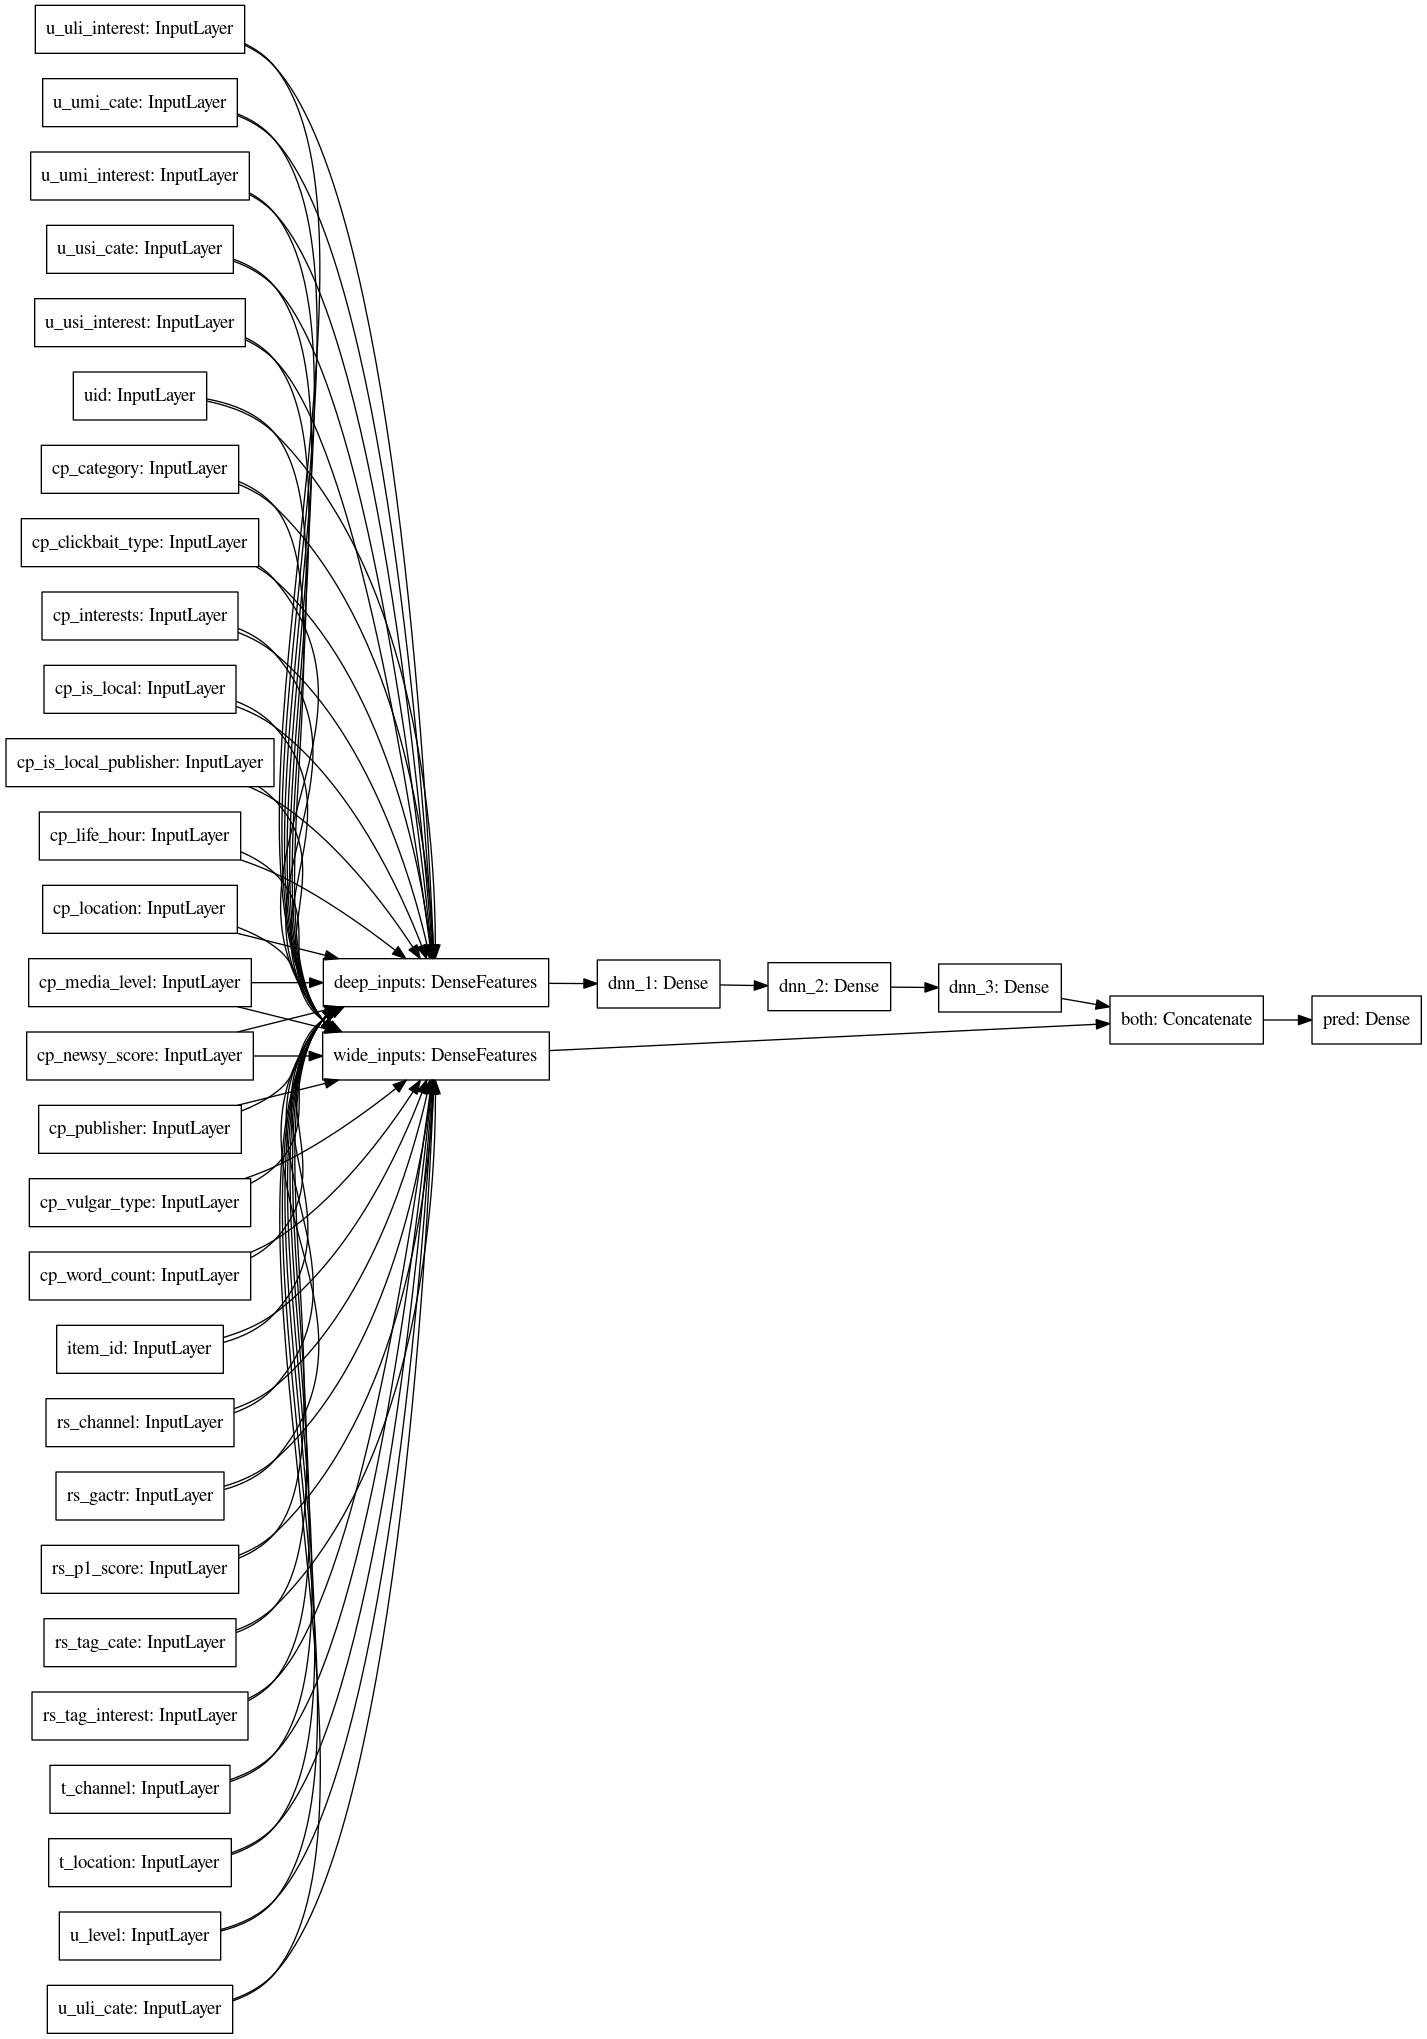

In [40]:
def wide_and_deep_classifier(inputs, linear_feature_columns, dnn_feature_columns, dnn_hidden_units):
    deep = tf.keras.layers.DenseFeatures(dnn_feature_columns, name='deep_inputs')(inputs)
    layers = [int(x) for x in dnn_hidden_units.split(',')]
    for layerno, numnodes in enumerate(layers):
        deep = tf.keras.layers.Dense(numnodes, activation='relu', name='dnn_{}'.format(layerno+1))(deep)        
    wide = tf.keras.layers.DenseFeatures(linear_feature_columns, name='wide_inputs')(inputs)
    both = tf.keras.layers.concatenate([deep, wide], name='both')
    output = tf.keras.layers.Dense(1, activation='sigmoid', name='pred')(both)
    model = tf.keras.Model(inputs, output)
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_crossentropy', 'accuracy', tf.keras.metrics.AUC()],
              run_eagerly=True)
    return model
    
model = wide_and_deep_classifier(
    inputs,
    linear_feature_columns = sparse.values(),
    dnn_feature_columns = real.values(),
    dnn_hidden_units = DNN_HIDDEN_UNITS)
tf.keras.utils.plot_model(model, 'wide_and_deep_model.png', show_shapes=False, rankdir='LR')

In [41]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cp_category (InputLayer)        [(None, 3)]          0                                            
__________________________________________________________________________________________________
cp_clickbait_type (InputLayer)  [(None, 1)]          0                                            
__________________________________________________________________________________________________
cp_interests (InputLayer)       [(None, 8)]          0                                            
__________________________________________________________________________________________________
cp_is_local (InputLayer)        [(None, 1)]          0                                            
______________________________________________________________________________________________

In [42]:
buffer_size = 5000
batch_size = 128

In [43]:
ftrain_dataset = train_dataset.shuffle(buffer_size).batch(batch_size)
ftest_dataset = test_dataset.shuffle(buffer_size).batch(batch_size)

In [ ]:
# 模型训练
model.fit(ftrain_dataset,
          validation_data=ftest_dataset,
          epochs=10, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=2)])

Epoch 1/10
    107/Unknown - 281s 3s/step - loss: 0.6337 - binary_crossentropy: 0.6337 - accuracy: 0.6394 - auc: 0.6621

In [110]:
# uncross feature result
files = list_sort_files(dir)
tmps = []
size = 0
for file in files:
    size += 1
    tmps.append(file)
#     print('train model use data from ', file)
    if size > 72:
        train_by_batch(tmps)
        tmps = []
        size = 0
if size > 0:
    train_by_batch(tmps)
    size = 0
